In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from utils.Training import Train
from utils.CustomDataset import CustomDataset
from Models.MAEClassifier import MAEClassifier
from Models.MaskedAutoEncoders import MaskedAutoEncoder

In [12]:
# Loading the data
axion_data, cdm_data, no_sub_data = [], [], []

LabelToId = {'axion': 0, 'cdm':1, 'no_sub':2}

# Walking through the test directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask6A/axion/"):
    for file in files:
        axion_data.append(np.load(os.path.join(root, file), allow_pickle=True)[0])

for root, dirs, files in os.walk("../dataset/DatasetTask6A/no_sub/"):
    for file in files:
        no_sub_data.append(np.load(os.path.join(root, file), allow_pickle=True))

for root, dirs, files in os.walk("../dataset/DatasetTask6A/cdm/"):
    for file in files:
        cdm_data.append(np.load(os.path.join(root, file), allow_pickle=True))


In [13]:
axion_data[0].shape, cdm_data[0].shape, no_sub_data[0].shape

((64, 64), (64, 64), (64, 64))

Text(0.5, 1.0, 'No Sub')

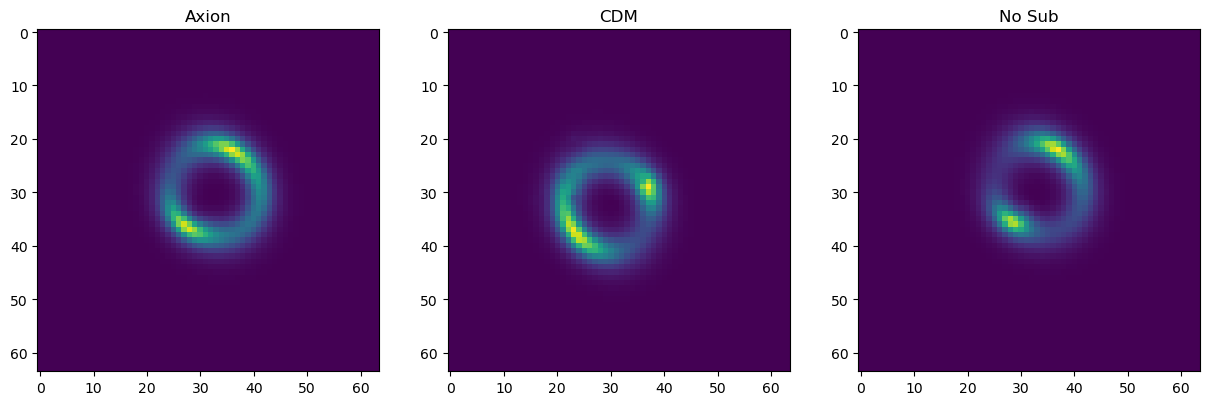

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(axion_data[0])
axes[0].set_title("Axion")

axes[1].imshow(cdm_data[0])
axes[1].set_title("CDM")

axes[2].imshow(no_sub_data[0])
axes[2].set_title("No Sub")

In [ ]:
# Creating the common dataset and dataloader
Labels = [0]*len(axion_data) + [1]*len(cdm_data) + [2]*len(no_sub_data)
Data = axion_data + cdm_data + no_sub_data

dataset = CustomDataset(Data, Labels)
train, test = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
TrainLoader = DataLoader(train, batch_size=32, shuffle=True)
TestLoader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
Encoder = MaskedAutoEncoder()
Encoder.load_state_dict(torch.load("../ModelWeights/MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth"))